<a href="https://colab.research.google.com/github/Li-Kane/CSE151A_project/blob/main/CSE151A_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview
**Goal:** We want to predict how long a diabetes patient will stay in the hospital. <br/>

**Dataset Stats:** 101766 rows with 47 features and 1 target feature. <br/>

**Features Used:** race, gender, age, num_procedures, num_medications, num_diagnoses, number_emergency, diabetesMed, readmitted<br/>

**Summary:** We chose the 9 best features that we believed would best predict how long a diabetes patient will stay in the hospital and dropped unnecessary features or features that had too many missing values (such as weight and medical_specialty). Then, we cleaned up missing values, encoded our data, plotted it, split it, and validated it. <br/>

**Dataset:**
https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008 <br/>

**Citations:** <br/>
Beata Strack, Jonathan P. DeShazo, Chris Gennings, Juan L. Olmo, Sebastian Ventura, Krzysztof J. Cios, and John N. Clore, “Impact of HbA1c Measurement on Hospital Readmission Rates: Analysis of 70,000 Clinical Database Patient Records,” BioMed Research International, vol. 2014, Article ID 781670, 11 pages, 2014.

**Members:** Lorentz Tuazon, Shijun Lun, Javier De La Cruz Zuniga, Rocky Hankin, Kane Li, Wesley Kiang, Su Aye, Asher James



In [1]:
!pip install ucimlrepo

from ucimlrepo import fetch_ucirepo

# fetch dataset
diabetes_130_us_hospitals_for_years_1999_2008 = fetch_ucirepo(id=296)

/usr/local/lib/python3.10/dist-packages/ucimlrepo/fetch.py:97: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)


In [2]:
#dependencies
import numpy as np
import seaborn as sns
import pandas as pd

from matplotlib import pyplot as plt
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro

# Data Cleaning
Extract our the features we want to use and handle NaN, Null, and other missing values

In [43]:
#load the features we want to use and target as X's and y's
features = diabetes_130_us_hospitals_for_years_1999_2008.data.features

#Since we use readmitted as a feature, which is the original targets, we have to join it to features
readmissions = diabetes_130_us_hospitals_for_years_1999_2008.data.targets
diabetes_ds = pd.concat([features, readmissions], axis=1)

#grab our relevant features
key_features = ['race', 'gender', 'age', 'num_procedures', 'num_medications', 'number_emergency', 'number_diagnoses', 'diabetesMed', 'readmitted']
X = diabetes_ds[key_features]

# our model's goal is to predict time in hospital
y = diabetes_ds[['time_in_hospital']]

# If you want to see X or y
X.head(5)
#y.head(10)

,race,gender,age,num_procedures,num_medications,number_emergency,number_diagnoses,diabetesMed,readmitted
0,Caucasian,Female,[0-10),0,1,0,1,No,NO
1,Caucasian,Female,[10-20),0,18,0,9,Yes,>30
2,AfricanAmerican,Female,[20-30),5,13,0,6,Yes,NO
3,Caucasian,Male,[30-40),1,16,0,7,Yes,NO
4,Caucasian,Male,[40-50),0,8,0,5,Yes,NO


In [44]:
#see where the NaN/null values are (y has no NaN)
X.isna().sum()
#y.isna().sum()

race                2273
gender                 0
age                    0
num_procedures         0
num_medications        0
number_emergency       0
number_diagnoses       0
diabetesMed            0
readmitted             0
dtype: int64

In [45]:
#drop Null race values
X = X.dropna(axis=0)
X.isna().sum()

race                0
gender              0
age                 0
num_procedures      0
num_medications     0
number_emergency    0
number_diagnoses    0
diabetesMed         0
readmitted          0
dtype: int64

# Encoding
Race: One-hot-encoding.

Gender: Convert to binary. 1 for Male, 0 for Female.

Age: Convert to the middle of the range. Ex. 10-20 becomes 15

Diabetes_med: Convert to binary. 1 for yes, 0 for no.

Readmitted: A column for <30, and >30, and not readmitted. Direct numerical
progression, so we can do label encoding. 0, 1, 2.

In [46]:
#one-hot-encode race
race_ohe = pd.get_dummies(X['race'], prefix='race')
X = X.drop('race', axis=1)
X = pd.concat([race_ohe, X], axis=1)

In [47]:
#gender convert to binary
for index, value in X['gender'].items():
    if value == 'Male':
        X.at[index, 'gender'] = 1
    elif value == 'Female':
        X.at[index, 'gender'] = 0

In [48]:
#age convert to middle of range
for index, value in X['age'].items():
    lower, higher = value.split('-')
    lower = int(lower[1:])
    higher = int(higher[:-1])
    middle = (lower + higher) // 2
    X.at[index, 'age'] = middle

In [49]:
#diabetes med convert to binary
for index, value in X['diabetesMed'].items():
    if value == 'No':
        X.at[index, 'diabetesMed'] = int(0)
    elif value == 'Yes':
        X.at[index, 'diabetesMed'] = int(1)

In [50]:
#label encode readmitted
for index, value in X['readmitted'].items():
    if value == 'NO':
        X.at[index, 'readmitted'] = int(2)
    elif value == '>30':
        X.at[index, 'readmitted'] = int(1)
    elif value == '<30':
        X.at[index, 'readmitted'] = int(0)

In [53]:
#Verify encoding
X.head(10)

,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender,age,num_procedures,num_medications,number_emergency,number_diagnoses,diabetesMed,readmitted
0,0,0,1,0,0,0,5,0,1,0,1,0,2
1,0,0,1,0,0,0,15,0,18,0,9,1,1
2,1,0,0,0,0,0,25,5,13,0,6,1,2
3,0,0,1,0,0,1,35,1,16,0,7,1,2
4,0,0,1,0,0,1,45,0,8,0,5,1,2
5,0,0,1,0,0,1,55,6,16,0,9,1,1
6,0,0,1,0,0,1,65,1,21,0,7,1,2
7,0,0,1,0,0,1,75,0,12,0,8,1,1
8,0,0,1,0,0,0,85,2,28,0,8,1,2
9,0,0,1,0,0,0,95,3,18,0,8,1,2


# Normalize and Standardize Data
To improve training stability and performance, we use MinMaxScaling to normalize age, num_procedures, num_medications, number__emergency, and number_diagnoses. Then, we use StandardScaler to standardize all the data to a normal distribution.

In [54]:
#normalize input data
from sklearn.preprocessing import minmax_scale

#Only normalize cols whose values vary a lot
scaleCols = ['age', 'num_procedures', 'num_medications', 'number_emergency', 'number_diagnoses']
X[scaleCols] = minmax_scale(X[scaleCols])
X.head(5)

,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender,age,num_procedures,num_medications,number_emergency,number_diagnoses,diabetesMed,readmitted
0,0,0,1,0,0,0,0.000000,0.000000,0.0000,0.0,0.000000,0,2
1,0,0,1,0,0,0,0.111111,0.000000,0.2125,0.0,0.533333,1,1
2,1,0,0,0,0,0,0.222222,0.833333,0.1500,0.0,0.333333,1,2
3,0,0,1,0,0,1,0.333333,0.166667,0.1875,0.0,0.400000,1,2
4,0,0,1,0,0,1,0.444444,0.000000,0.0875,0.0,0.266667,1,2


In [56]:
#standardize the relevant columns
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X[scaleCols])
X[scaleCols] = scaler.transform(X[scaleCols])
X.head(5)

,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender,age,num_procedures,num_medications,number_emergency,number_diagnoses,diabetesMed,readmitted
0,0,0,1,0,0,0,-3.823191,-0.786858,-1.850624,-0.214199,-3.343217,0,2
1,0,0,1,0,0,0,-3.195979,-0.786858,0.243036,-0.214199,0.810353,1,1
2,1,0,0,0,0,0,-2.568767,2.147917,-0.372746,-0.214199,-0.747236,1,2
3,0,0,1,0,0,1,-1.941555,-0.199903,-0.003277,-0.214199,-0.228040,1,2
4,0,0,1,0,0,1,-1.314344,-0.786858,-0.988529,-0.214199,-1.266432,1,2


# Visualization

<ipython-input-57-561675b31a02>:6: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  complete = pd.concat([X, y], 1)
<ipython-input-57-561675b31a02>:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(complete.corr(), fmt = '.1g', annot = True, cbar=False)


<Axes: >

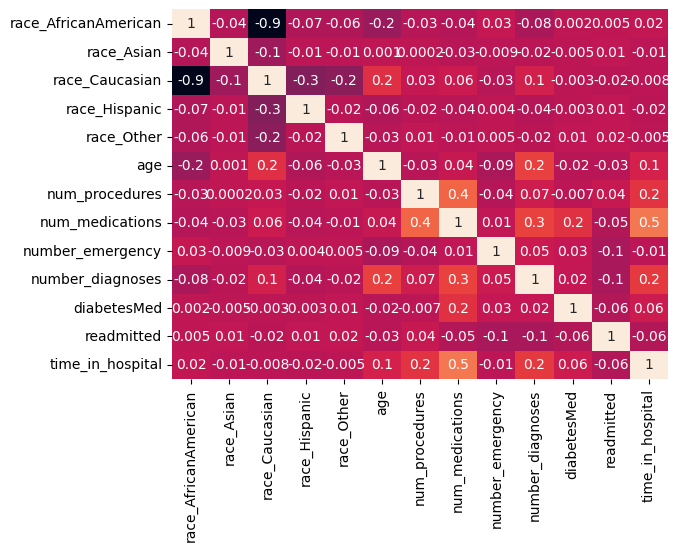

In [57]:
# visualizing data via correlation matrix (heatmap) and pair plot
# make sure everything's numerical
X = X.convert_dtypes(convert_string=False)

#we'll include our target data in our plot
complete = pd.concat([X, y], 1)
sns.heatmap(complete.corr(), fmt = '.1g', annot = True, cbar=False)

Observations from the heatmap:

1.   Most features aren't very correlated with each other
2.   The correlation between racial categories varies even though they're equally mutually exclusive
3.   By far the feature most correlated with the duration of the hospital stay is how many medications they're on.
4.   When we build our model to predict time in hospital, we should drop race, number of emergencies, readmission, and whether they're on medication as these have low correlation with the target.

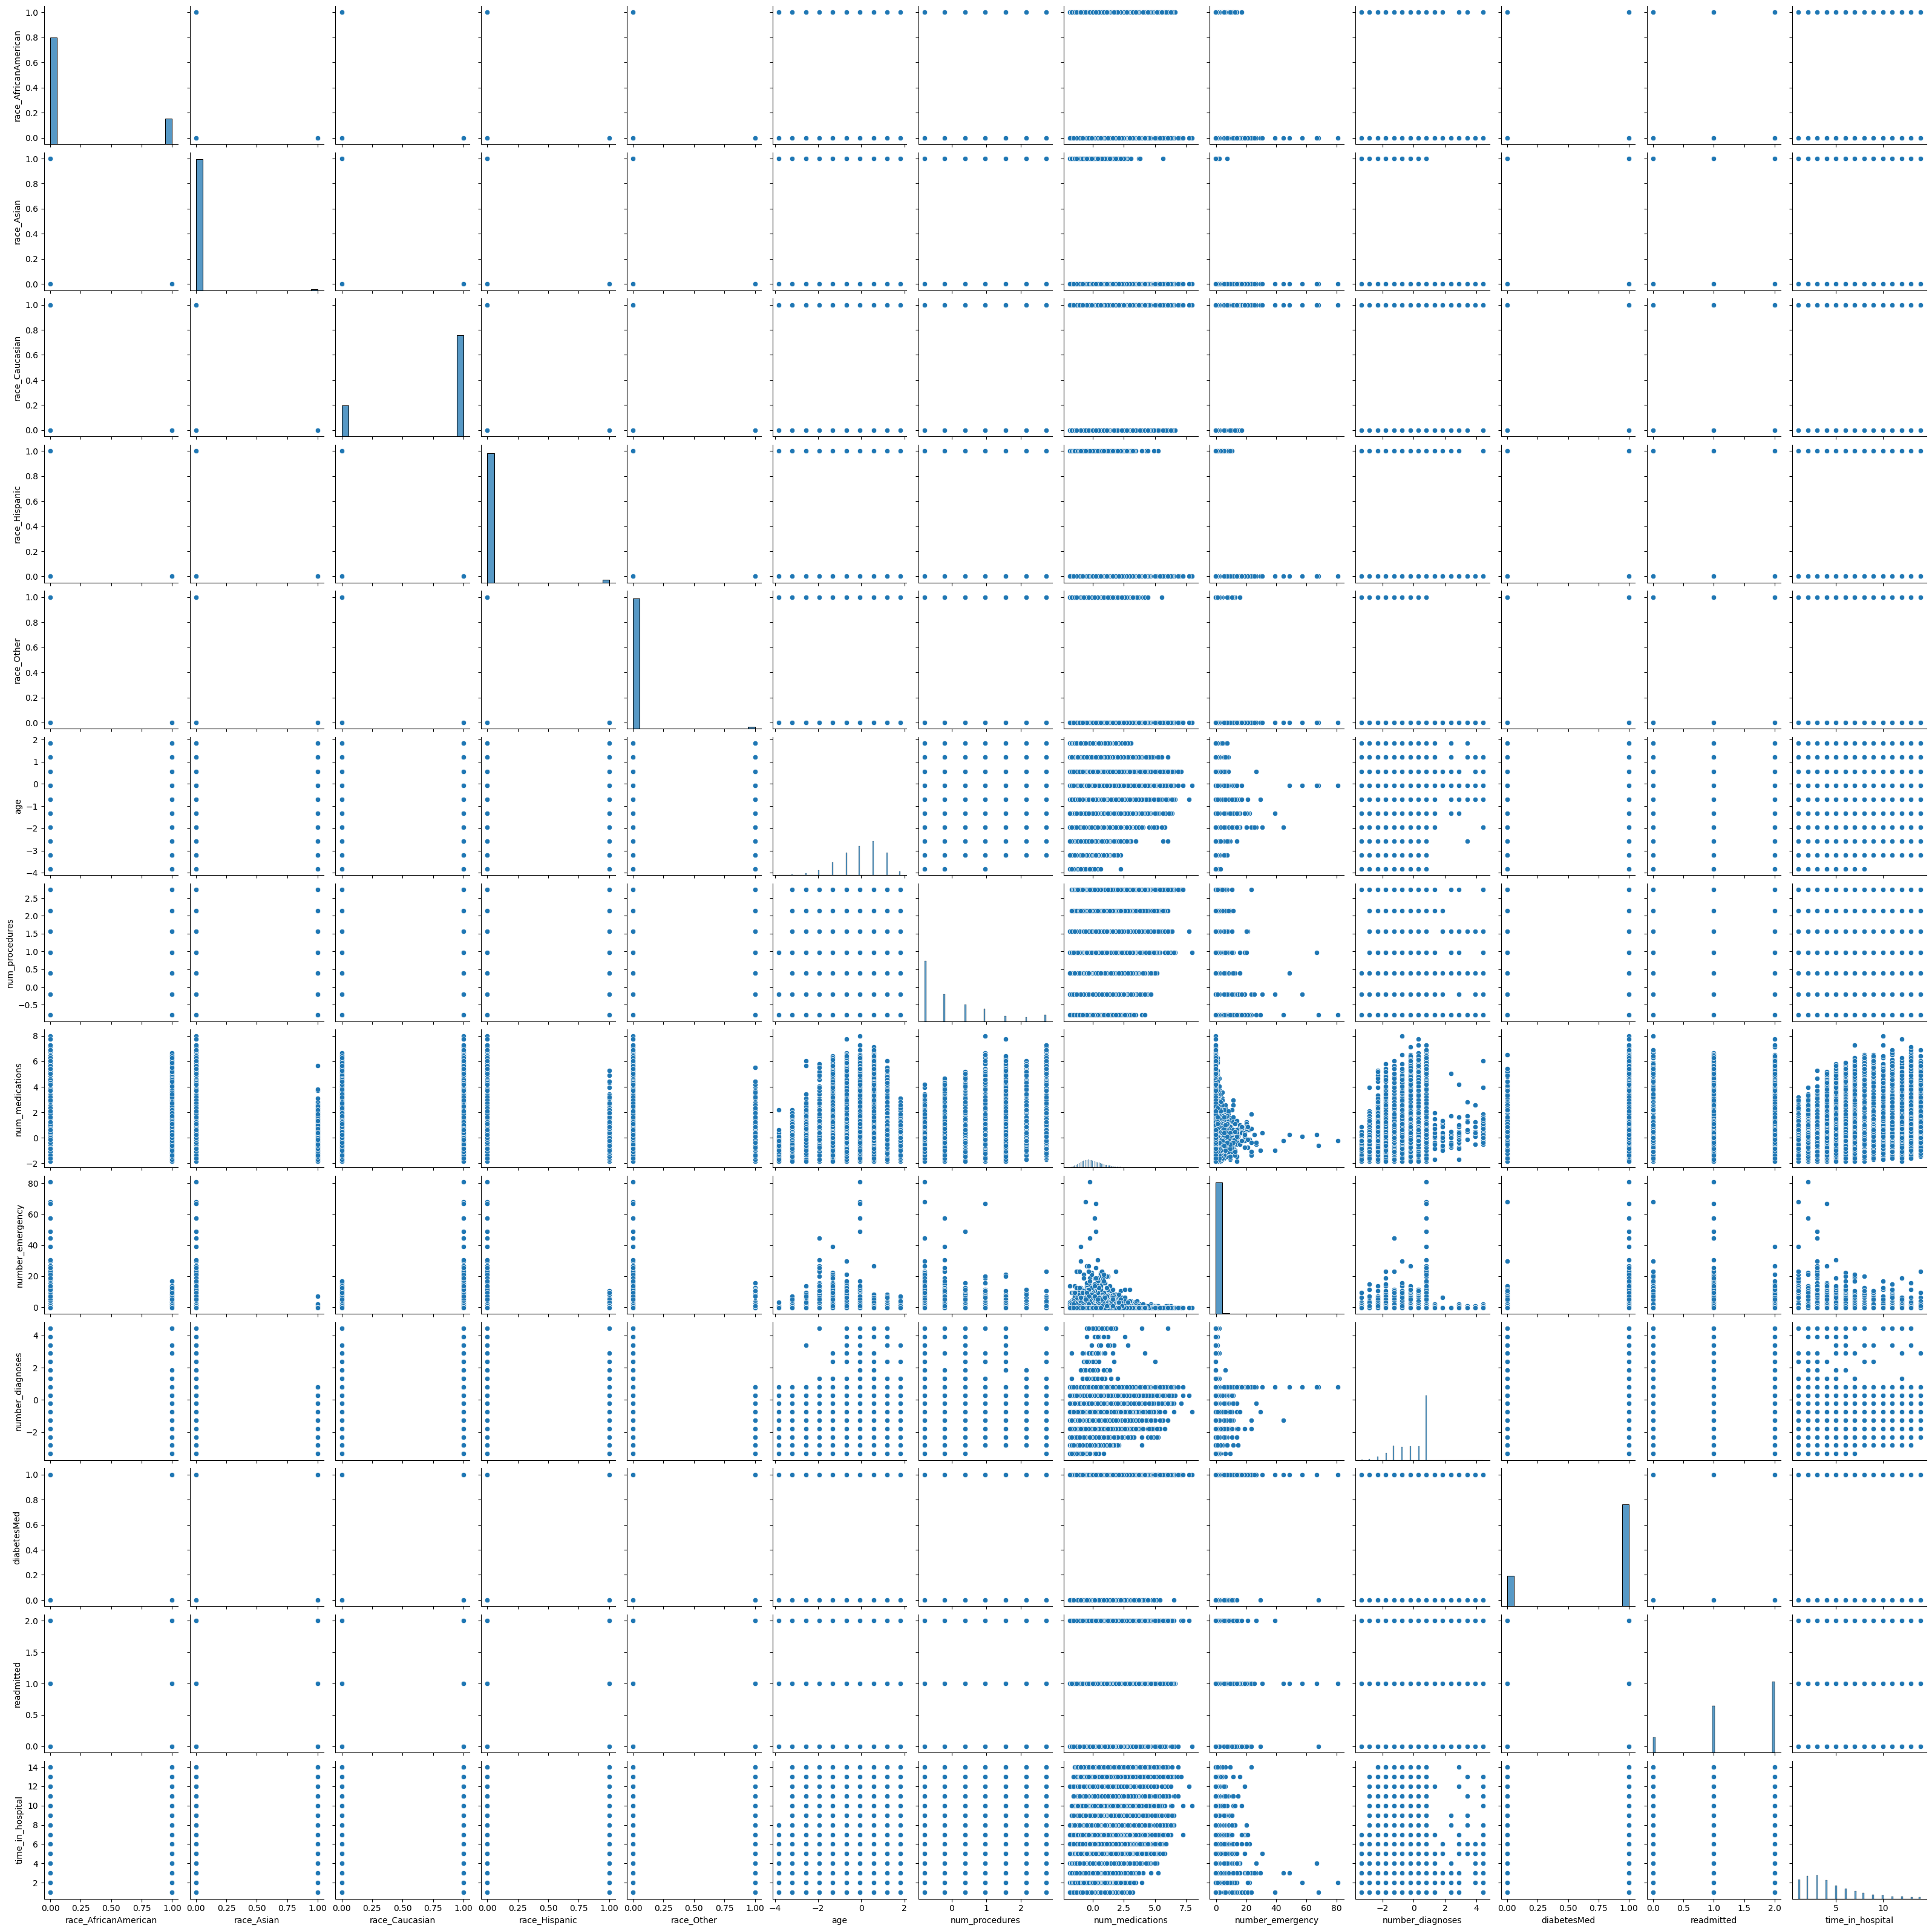

In [58]:
sns.pairplot(complete)

Observations from the pair plot

1.   Although they didn't show high correlation in the heatmap, num emergencies and num medications show a fairly distinct shape on their scatter plot. We can see everyone with a high number of emergencies wasn't on that much medication, but maybe this is a function of sample size.
2.   Num medications and age also have a distinct graph shape despite having low correlation on our heatmap.
3.   Number procedures vs. time in hospital is so perfectly square shaped its actually strikes me as odd
4.   Our data points for number of procedures are skewed heavily towards the highest value in range, that being 6.
5.   Caucasians are vastly over represented in the data set. They outnumber the other races combined by at least 3 to 1.

In [59]:
# shuffle data and split train test with seed
seed = 1
temp_df = pd.concat([X, y], axis=1)
temp_df = temp_df.sample(frac=1, random_state=seed)
train, test = np.split(temp_df, [int(np.round(temp_df.shape[0] * 0.8))])
X_train = train.iloc[:,:-1]
y_train = train.iloc[:,-1]
X_test = test.iloc[:,:-1]
y_test = test.iloc[:,-1]

# Data Verification

Ensure our data follows the expected distributions and values.

### Datatype validation

In [60]:
X.dtypes

race_AfricanAmerican      UInt8
race_Asian                UInt8
race_Caucasian            UInt8
race_Hispanic             UInt8
race_Other                UInt8
gender                   object
age                     Float64
num_procedures          Float64
num_medications         Float64
number_emergency        Float64
number_diagnoses        Float64
diabetesMed               Int64
readmitted                Int64
dtype: object

Datatype of the gender column in the dataframe indicates that there were still values not accounted for. We can drop these rows.

In [61]:
# Find column elements that are neither 0 nor 1
X['gender'].unique()

array([0, 1, 'Unknown/Invalid'], dtype=object)

In [62]:
# Drop rows that contain extraneous element & convert column to numerical
filter = X['gender'] == 'Unknown/Invalid'
X = X[~filter]
X['gender'] = pd.to_numeric(X['gender'])

# Verify dtype for dataframe
X.dtypes

<ipython-input-62-3af2f3c0e048>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['gender'] = pd.to_numeric(X['gender'])


race_AfricanAmerican      UInt8
race_Asian                UInt8
race_Caucasian            UInt8
race_Hispanic             UInt8
race_Other                UInt8
gender                    int64
age                     Float64
num_procedures          Float64
num_medications         Float64
number_emergency        Float64
number_diagnoses        Float64
diabetesMed               Int64
readmitted                Int64
dtype: object

race_AfricanAmerican
ShapiroResult(statistic=0.48200178146362305, pvalue=0.0)


/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


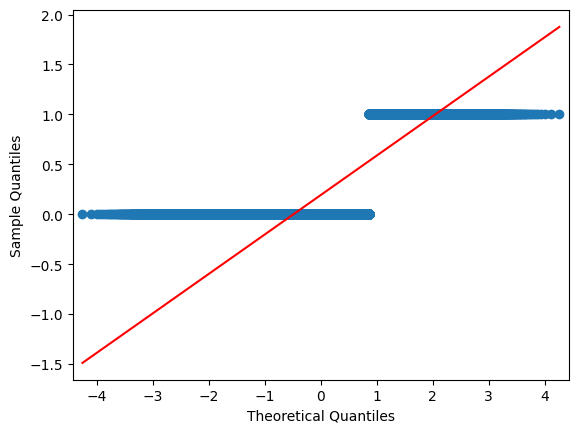

race_Asian
ShapiroResult(statistic=0.05123013257980347, pvalue=0.0)


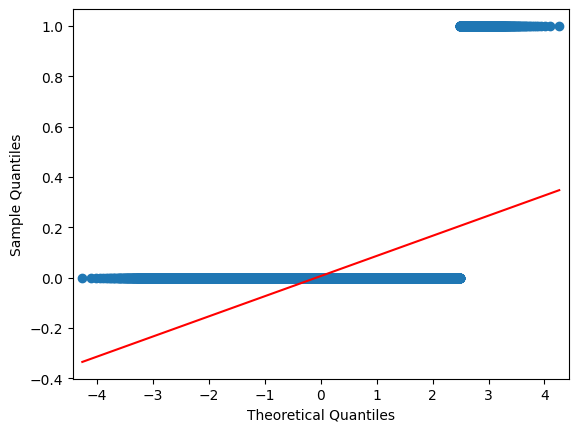

race_Caucasian
ShapiroResult(statistic=0.5253992080688477, pvalue=0.0)


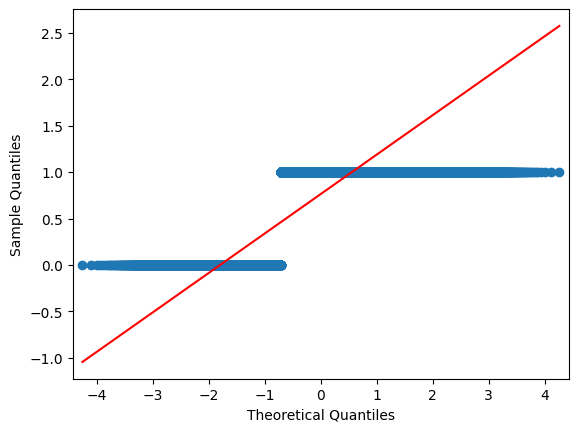

race_Hispanic
ShapiroResult(statistic=0.12162750959396362, pvalue=0.0)


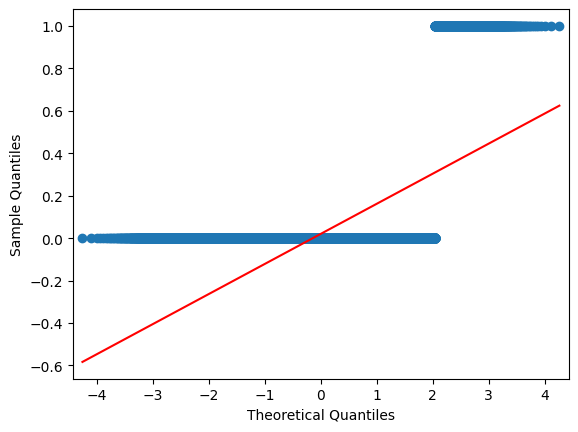

race_Other
ShapiroResult(statistic=0.09766680002212524, pvalue=0.0)


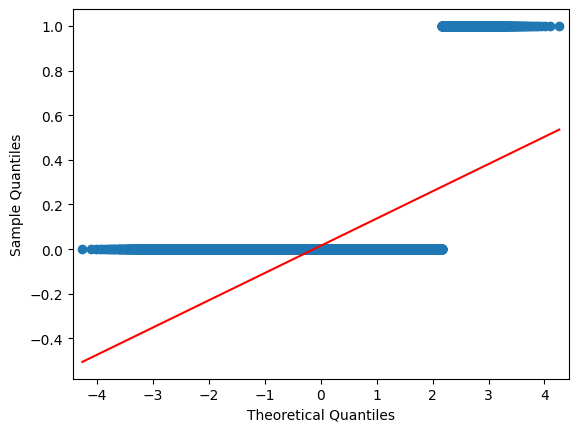

gender
ShapiroResult(statistic=0.6352283358573914, pvalue=0.0)


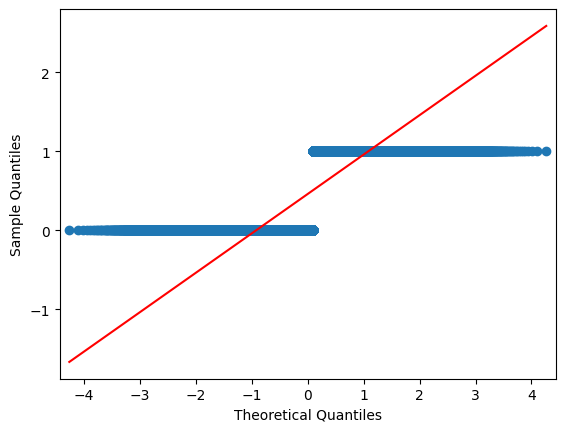

age
ShapiroResult(statistic=0.9394146800041199, pvalue=0.0)


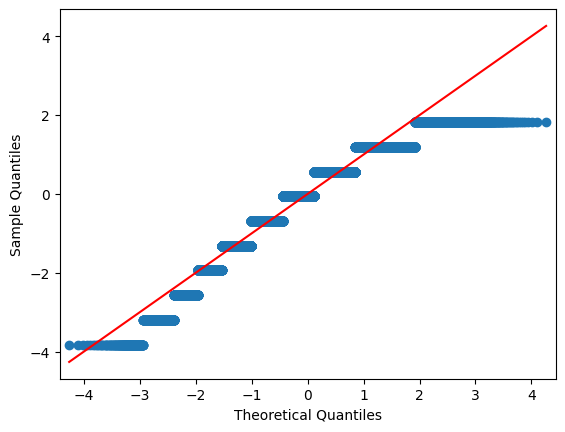

num_procedures
ShapiroResult(statistic=0.775197446346283, pvalue=0.0)


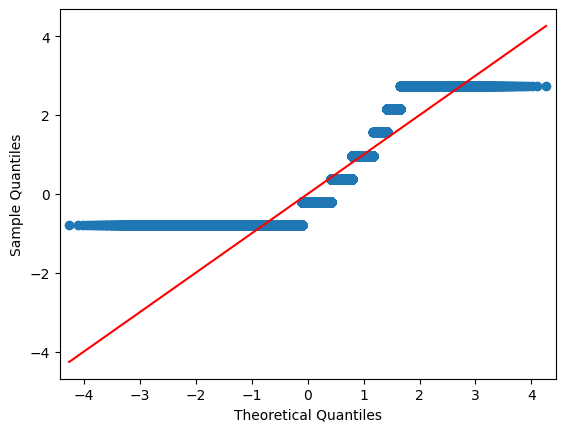

num_medications
ShapiroResult(statistic=0.9248144030570984, pvalue=0.0)


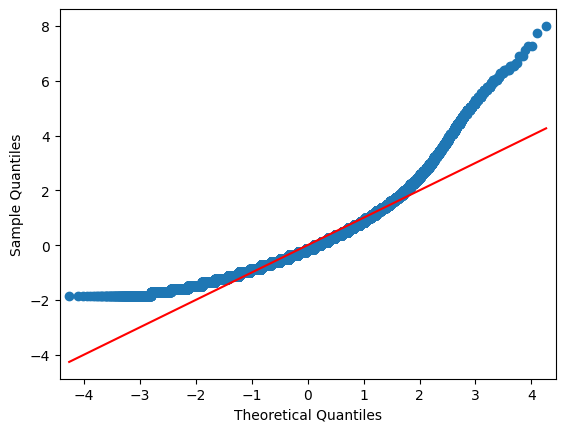

number_emergency
ShapiroResult(statistic=0.19951218366622925, pvalue=0.0)


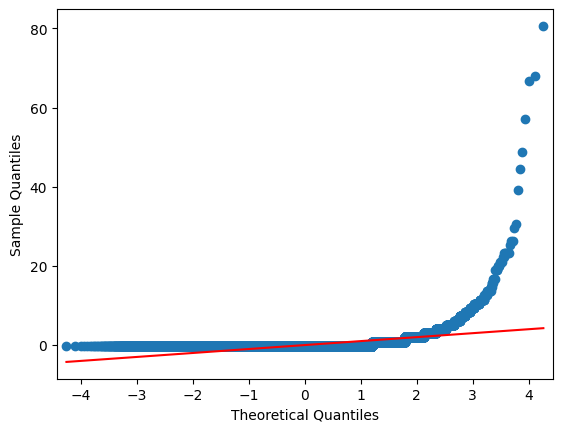

number_diagnoses
ShapiroResult(statistic=0.8009591698646545, pvalue=0.0)


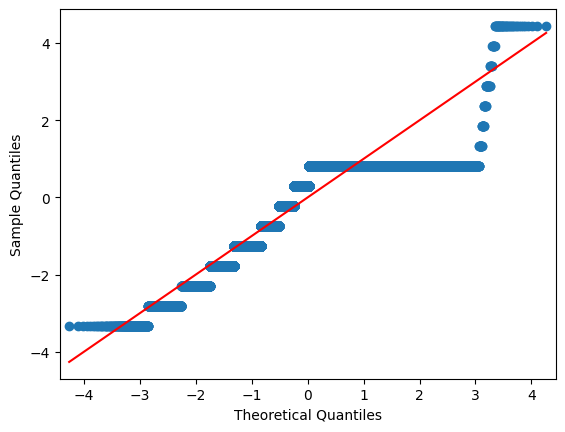

diabetesMed
ShapiroResult(statistic=0.5218844413757324, pvalue=0.0)


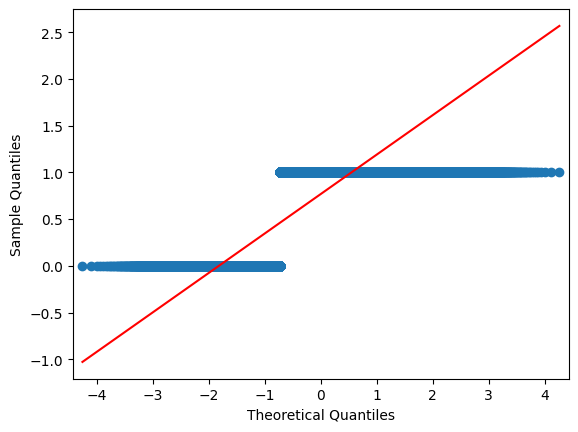

readmitted
ShapiroResult(statistic=0.7380174994468689, pvalue=0.0)


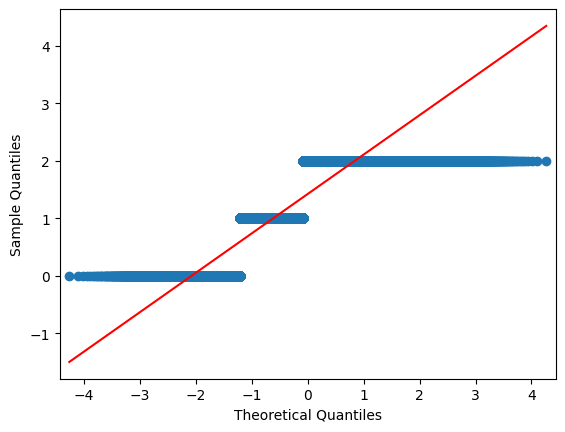

In [63]:
# Use QQ-plot & Shapiro-Wilkes test for normality
for col in X.columns:
    print(col)
    print(shapiro(X[col]))
    qqplot(X[col], line='s')
    plt.show()

While it is expected that labels such as gender and race aren't normally distributed, we see from the QQ plots & the resulting p-values that our normalized and standardized columns do not follow the normal distribution very well, indicating that we may need to revisit our methods of normalizatiion & standardization. However, they do roughly follow a normal distribution.